# CYPLAN 255 Project

## Using Open-Source Bike Share Trip Data to Inform Social Distancing Street Closures

### `2_Densify_BayWheels_Trips`

With the data cleaned and processed it is time to translate the routes generated in `1_Process_BayWheels_Trips.ipynb` into recommendations for street closures. In order to do this we want to identify the most frequented pathsThis data does less processing and more exploratory analysis to visualize the Bay Wheels origin-destination trips. The charts and figures created in this notebook can be used to set the stage for further analysis and provide background information on the data.

**Datasets used:**
* [System data](https://www.lyft.com/bikes/bay-wheels/system-data) from Bay Wheels. We process only trips from February 2020 because it is the latest dataset available (most current station layout and trip flows).
* [Regional bicycle facilities](http://opendata.mtc.ca.gov/datasets/regional-bike-facilities?geometry=-122.400%2C37.800%2C-122.144%2C37.847) in the Bay Area. From the Metropolitan Transportation Commission.
* Census boundaries for California, including polygons for the state outline, census-designated places, and tracts.

**Notebook summary:**
* 2.0 - Import packages
* 2.1 - Import data
* 2.2 - 
* 2.3 - 

## 2.1 Initialize

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import time
from tqdm import tqdm

In [30]:
from shapely.geometry import Polygon, LineString, Point

In [3]:
crs = 'epsg:4326'
crs_project = 'epsg:3310'

## 2.2. Load Data

In [4]:
# load processed trips data (with routes)
trips_gdf = gpd.read_file("../data/baywheels_routes_osmnx.geojson")

In [5]:
# load geodataframe of stations
stations = gpd.read_file("../data/baywheels_stations.geojson")

In [6]:
# load bounding boxes for station regions
bbox_gdf = gpd.read_file("../data/baywheels_regions_bbox.geojson")

In [7]:
# load bicycle facilities in Bay Area
facilities = gpd.read_file("../data/regional_bike_facilities.geojson")

# class / class_type :
# 1 = 'Off-Street Shared-Use Path'
# 2 = 'Bike Lane'
# 3 = 'On-Street Bike Route'

## 2.3 Split lines to find unique routes

The geodataframe of trips has a geometry field with the shortest path between the origin and destination station for every trip (cleaned) taken in February 2020. In order to identify the most frequented routes some geometric calculations need to be applied to our data. Let's start by plotting the routes we have so far.


* https://gis.stackexchange.com/questions/202958/merging-overlapping-features-using-geopandas
* [not used but maybe useful](https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/) - locating high risk traffic areas with shapely, fiona

In [10]:
trips_gdf.head()

,start_station_id,end_station_id,count,start_node,end_node,region,geometry
0,3.0,4.0,5,6489941287,65313138,San Francisco,"LINESTRING (-122.40508 37.78638, -122.40523 37..."
1,5.0,4.0,2,1723739163,65313138,San Francisco,"LINESTRING (-122.40807 37.78401, -122.40853 37..."
2,6.0,4.0,2,33241803,65313138,San Francisco,"LINESTRING (-122.40345 37.80504, -122.40228 37..."
3,10.0,4.0,1,65374771,65313138,San Francisco,"LINESTRING (-122.40497 37.79533, -122.40565 37..."
4,11.0,4.0,3,65328969,65313138,San Francisco,"LINESTRING (-122.39835 37.79709, -122.39819 37..."


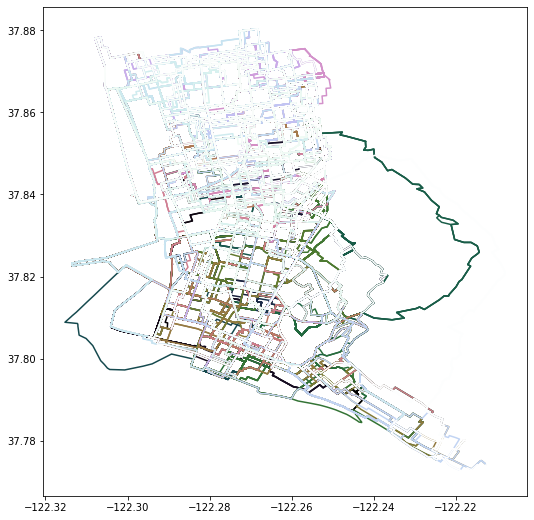

In [11]:
# Plot routes
trips_gdf.loc[trips_gdf.region=="East Bay"].plot(figsize=(9,9), cmap='cubehelix')

That is very messy. Many of the routes are overlapping and it is unclear how many trips are actually taken down each street.

Before trying to tease out the number of trips down each street let's simplify this dataset. Below we use the `.unary_union` method on the trips geometry field to merge overlapping segments. This process outputs a geodataframe with only unique trip segments.

In [10]:
# lines_split = []
# for geom in trips_gdf.loc[trips_gdf.region=="East Bay"].geometry.unary_union:
#     lines_split.append(geom)
# print(len(lines_split))

In [11]:
# Create empty array to store route segments
lines_split = []

# Loop through every unique bit of geometry in the geodataframe and append it
# to the empty array created above.
# This is done within a loop of the regions because processing the whole geodataframe
# geometry through unary_union at once was taking too long and crashing tabs on my
# computer.
regions = list(bbox_gdf.region)
for r in regions[:1]:
    for geom in trips_gdf.loc[trips_gdf.region==r].geometry.unary_union:
        lines_split.append(geom)
# The code above was further edited to only select the routes in the 'East Bay' region because
# the geometry.unary_union kept crashing when ran on 'San Francsico' routes. Unsure why currently.

# Save route segments to a geodataframe
split_gdf = gpd.GeoDataFrame(crs=crs, geometry=lines_split)

# Print length of routes geodataframe
# print(len(trips_gdf))
print(len(trips_gdf.loc[trips_gdf.region==r]))

# Print length of split geodataframe
print(len(split_gdf))

23744
5185


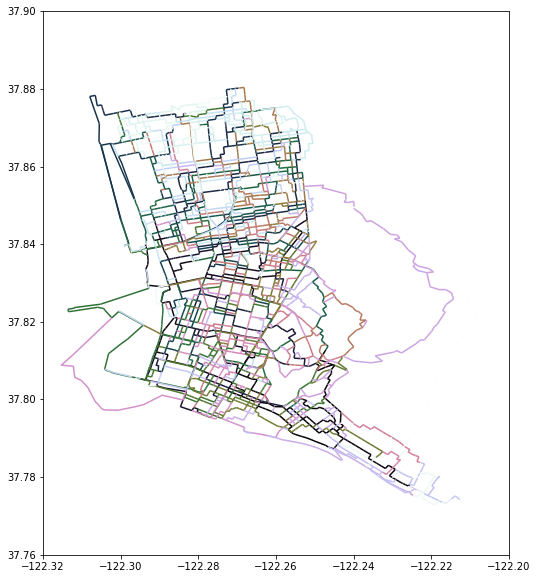

In [22]:
# Display new geodataframe of route segments
fig, ax = plt.subplots(figsize=(10,10))

split_gdf.plot(ax=ax, cmap='cubehelix')

bounds = bbox_gdf.loc[bbox_gdf.region=='East Bay'].geometry.bounds
ax.set_xlim((bounds.minx[0], bounds.maxx[0]))
ax.set_ylim((bounds.miny[0], bounds.maxy[0]))

plt.show()

Much cleaner. Instead of overlapping lines this dataset has unique LineStrings for each possible route segment. The process above dropped all descriptive attributes from the dataframe though so we will need to intersect this geodataframe and the one of all the routes to get information on the frequency in which each LineString is used for Bay Wheels trips.

In [29]:
# Display split_gdf table...only geometric attributes
split_gdf.head()

,geometry
0,"LINESTRING (-122.27119 37.80432, -122.27162 37..."
1,"LINESTRING (-122.27162 37.80363, -122.27206 37..."
2,"LINESTRING (-122.27206 37.80295, -122.27249 37..."
3,"LINESTRING (-122.27249 37.80226, -122.27127 37..."
4,"LINESTRING (-122.27127 37.80178, -122.27009 37..."


In [60]:
# Add an id column to the segments that is different from the index.
# This id is one-indexed to differentiate it from the gpd index.
# This id will be needed after we intersect these segments with the trips LineStrings
split_gdf['seg_id'] = range(1,len(split_gdf)+1)

In [50]:
# Spatially join the segments with the routes. This will create a new geodataframe 
# with a record for every intersection between the two geodataframes. We use an inner
# join because it creates duplicates of the split_gdf LineStrings and while preserving
# that geometry. This is what we want: counts of the trips over each segment.

# Code source:
# * https://stackoverflow.com/questions/28752044/getting-counts-of-intersections-between-geometries-in-geopandas
# * https://github.com/agile-geoscience/notebooks/blob/master/Programming_a_seismic_program.ipynb
# * https://geopandas.org/reference/geopandas.sjoin.html?highlight=sjoin#geopandas.sjoin

sjoin_gdf = gpd.tools.sjoin(split_gdf, trips_gdf)

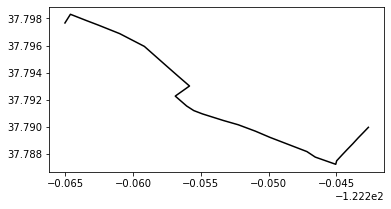

In [65]:
# Display what one route looks like
trips_gdf.loc[(trips_gdf.start_station_id==163) & (trips_gdf.end_station_id==46)].plot(cmap='cubehelix')

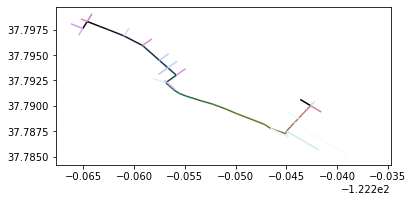

In [64]:
# Display what the intersection of the route with the segments looks like
sjoin_gdf.loc[(sjoin_gdf.start_station_id==163) & (sjoin_gdf.end_station_id==46)].plot(cmap='cubehelix')

Almost there. The spatial join tool is grabbing segments that bisect the route of interest but we only want the ones that are exact overlaps. Let's try again using a different join method: `within`. See [the docs](https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates) for more information on this join method (and why this is used instead of `contains`).

In [66]:
# Spatial join with different method
sjoin_gdf = gpd.tools.sjoin(split_gdf, trips_gdf, op='within')

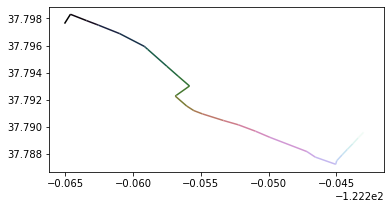

In [67]:
# Display what the intersection of the route with the segments looks like
sjoin_gdf.loc[(sjoin_gdf.start_station_id==163) & (sjoin_gdf.end_station_id==46)].plot(cmap='cubehelix')

In [73]:
# Display table of what routes intersect a random segment.
# The output is sorted by start and end station id for clarity in reading the data.
sjoin_gdf.loc[(sjoin_gdf.seg_id==42)].sort_values(by=['start_station_id', 'end_station_id'])

,geometry,seg_id,index_right,start_station_id,end_station_id,count,start_node,end_node,region
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,18333,162.0,201.0,2,53027368,3101110489,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,19891,163.0,7.0,17,53055597,3244767454,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,16608,163.0,46.0,2,53055597,53073053,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,19973,163.0,149.0,1,53055597,53073991,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,16912,163.0,162.0,39,53055597,53027368,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,20113,163.0,171.0,2,53055597,53090703,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,22986,163.0,172.0,1,53055597,53090707,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,17314,163.0,178.0,5,53055597,5478169456,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,17388,163.0,179.0,2,53055597,283261632,East Bay
41,"LINESTRING (-122.26505 37.79762, -122.26462 37...",42,17444,163.0,180.0,2,53055597,53099355,East Bay


In [74]:
# Return the number of trips that travel along this segment
sum(sjoin_gdf.loc[(sjoin_gdf.seg_id==42)]['count'])

756

In [78]:
# Group geodataframe to get back to unique segments but now with counts
sjoin_group_gdf = sjoin_gdf.groupby('seg_id').agg({'count': 'count'})

# Reset index so not indexed on seg_id
sjoin_group_gdf.reset_index(inplace=True)

# Merge geometry with the grouped dataframe with counts per segment
sjoin_group_gdf = split_gdf.merge(sjoin_group_gdf, on='seg_id')

# Display grouped gdf
sjoin_group_gdf.head()

,geometry,seg_id,count
0,"LINESTRING (-122.27119 37.80432, -122.27162 37...",1,188
1,"LINESTRING (-122.27162 37.80363, -122.27206 37...",2,156
2,"LINESTRING (-122.27206 37.80295, -122.27249 37...",3,140
3,"LINESTRING (-122.27249 37.80226, -122.27127 37...",4,80
4,"LINESTRING (-122.27127 37.80178, -122.27009 37...",5,107


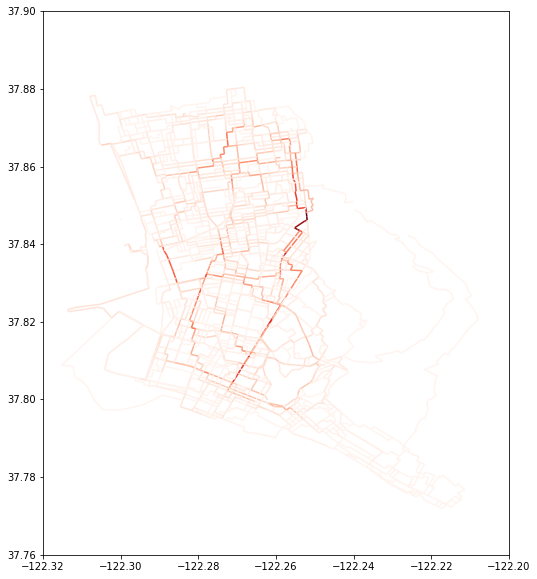

In [83]:
# Display geodataframe of route segments...now with counts!
fig, ax = plt.subplots(figsize=(10,10))

sjoin_group_gdf.plot(ax=ax, column='count', cmap='Reds')

bounds = bbox_gdf.loc[bbox_gdf.region=='East Bay'].geometry.bounds
ax.set_xlim((bounds.minx[0], bounds.maxx[0]))
ax.set_ylim((bounds.miny[0], bounds.maxy[0]))

plt.show()

Now that is what we wanted! Darker reds indicate more trips over that segment, which means they are frequented bike paths. Many of these routes may only have a couple trips on them so lets filter this dataset more to hone in on the most used segments.

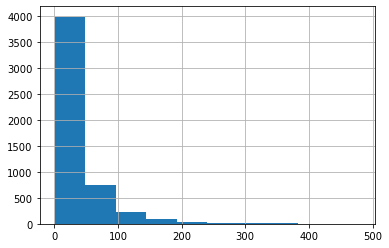

In [86]:
# Histogram of trips per segment
sjoin_group_gdf['count'].hist()

In [87]:
# Describe trips per segment
sjoin_group_gdf['count'].describe()

count    5139.000000
mean       35.237400
std        48.010939
min         1.000000
25%         6.000000
50%        19.000000
75%        45.000000
max       479.000000
Name: count, dtype: float64

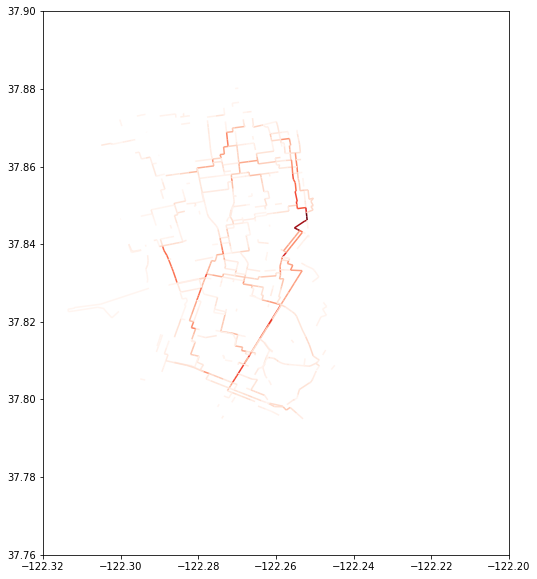

In [88]:
# Replot only segments with over 50 trips
# Display geodataframe of route segments...now with counts!
fig, ax = plt.subplots(figsize=(10,10))

sjoin_group_gdf.loc[sjoin_group_gdf['count']>=50].plot(ax=ax, column='count', cmap='Reds')

bounds = bbox_gdf.loc[bbox_gdf.region=='East Bay'].geometry.bounds
ax.set_xlim((bounds.minx[0], bounds.maxx[0]))
ax.set_ylim((bounds.miny[0], bounds.maxy[0]))

plt.show()

Plot the route segments in folium so we can look at it over the street network. [Documentation](https://python-visualization.github.io/folium/quickstart.html).

In [94]:
import folium

In [103]:
m_centroid = bbox_gdf.loc[bbox_gdf.region=='East Bay'].centroid[0]

In [112]:
# Initialize map
m = folium.Map(location=[m_centroid.y, m_centroid.x], 
               zoom_start=14)

# Loop through segments, add to map
for index, row in sjoin_group_gdf.loc[sjoin_group_gdf['count']>=50].iterrows():
    coords = list(row.geometry.coords)
    folium.PolyLine(coords).add_to(m)

# Display map
m

## TESTING BELOW

The next step is to identify how frequently Bay Wheels riders traversed each of these segments.



In [160]:
# Project trips_gdf, which is necessary to get length measurements in meters and not degrees
trips_gdf = trips_gdf.to_crs('epsg:3310')

# Generate points every 50 meters along each linestring in trips_gdf.
# Equivalent to the densify tool in ArcGIS.
# Method found from: 
#  - https://gis.stackexchange.com/questions/309251/how-to-get-equidistant-points-from-a-linestring-geographical-coordinates
#  - https://shapely.readthedocs.io/en/stable/manual.html#linear-referencing-methods
trips_eb = trips_gdf.loc[trips_gdf.start_region=="East Bay"]
pt_coords = []
for i in tqdm(range(len(trips_eb))):
    length = trips_eb.iloc[i].geometry.length
    while length > 0:
        pt_coords.append(trips_eb.iloc[i].geometry.interpolate(length))
        length -= 50
    pt_coords.append(trips_eb.iloc[i].geometry.interpolate(0))

# print(len(coords))
# for i in coords:
#     print(i)

100%|██████████████████████████████████████████████████████████████████████████████| 5246/5246 [04:21<00:00, 20.07it/s]


In [ ]:
# convert list of points to a gdf of points
densify_gdf = gpd.GeoDataFrame(crs='epsg:3310', geometry=pt_coords)
del pt_coords

# Project densify_gdf to WGS84 so we can plot with lat/lon
densify_gdf = densify_gdf.to_crs('epsg:4326')

In [161]:
# create new columns with lat and lon coordinates
densify_gdf['lon'] = densify_gdf.geometry.x
densify_gdf['lat'] = densify_gdf.geometry.y

In [167]:
densify_gdf.head()

,geometry,lon,lat
0,POINT (-122.24261 37.79001),-122.242608,37.790012
1,POINT (-122.24306 37.79028),-122.243061,37.790284
2,POINT (-122.24351 37.79056),-122.243515,37.790555
3,POINT (-122.24396 37.79084),-122.243956,37.790837
4,POINT (-122.24389 37.79115),-122.243889,37.791149


In [162]:
# import coastline shapefile
outlines = gpd.read_file('zip://../data/cb_2016_us_state_500k.zip')

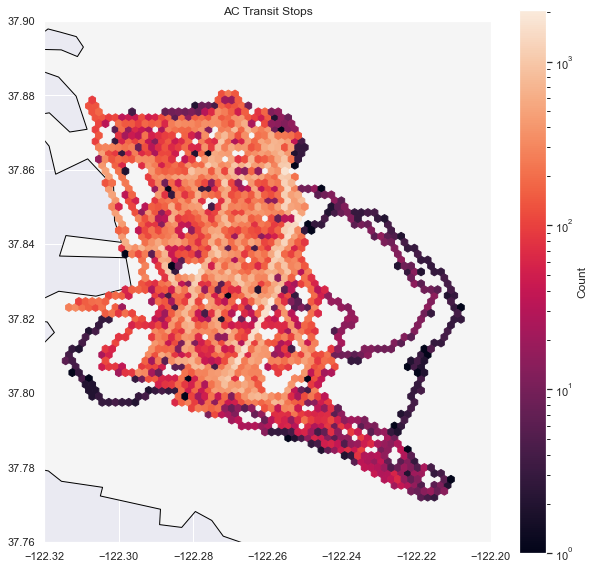

In [185]:
# plot static hexbin heatmap map of bus stops
fig, ax = plt.subplots(figsize=(10,10))

# Plot coastline using GeoPandas
outlines.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot hexbins of bus stops using Matplotlib
hb = plt.hexbin(densify_gdf.lon, densify_gdf.lat, bins='log', mincnt=1, gridsize=60)

# Add a key
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')

# Title and bounds
ax.set_title('AC Transit Stops')
ax.set_xlim((-122.32, -122.2))
ax.set_ylim((37.76, 37.9))

plt.show()

In [191]:
for i in range(1,5):
    print(i)

1
2
3
4


In [115]:
# print(trips_gdf.shape)
# auto_inter = gpd.overlay(trips_gdf, trips_gdf, how='intersection')
# print(auto_inter.shape)

(24154, 13)



KeyboardInterrupt



## MORE TESTING

In [186]:
# plot routes
# multi = trips_gdf.loc[trips_gdf.start_region=="San Jose"].geometry.unary_union

In [187]:
# multi = gpd.GeoSeries(multi)
# multi_df = gpd.GeoDataFrame(crs=crs, geometry=gpd.GeoSeries(multi))
# multi_df.geometry.explode()

In [188]:
# multi_df.head()

In [189]:
# list(trips_gdf.iloc[0].geometry.coords)

In [147]:
trips_gdf.iloc[0].geometry.interpolate(0).wkt

'POINT (-211500.4874227013 -22884.14504526602)'

In [148]:
list(trips_gdf.iloc[0].geometry.coords)[0]

(-211500.48742270132, -22884.14504526602)

In [141]:
x = 646
while x > 0:
    print(x)
    x -= 50

646
596
546
496
446
396
346
296
246
196
146
96
46


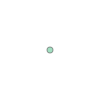

In [142]:
trips_gdf.iloc[0].geometry.interpolate(0.75, normalized=True)

* expand groupby df (1 row with 4 counts of linestring to 4 rows of 1 count of linestring)
*

In [ ]:
# https://gis.stackexchange.com/questions/238533/how-do-i-extract-points-from-a-linestring-or-polygon-data-frame-and-make-a-dicti
def linestring_to_points(feature,line):
    return {feature:line.coords}

gdf['points'] = gdf.apply(lambda l: linestring_to_points(l['xs_ID],l['geometry']),axis=1)

In [ ]:
multi_df.plot(figsize=(9,9), cmap='cubehelix')

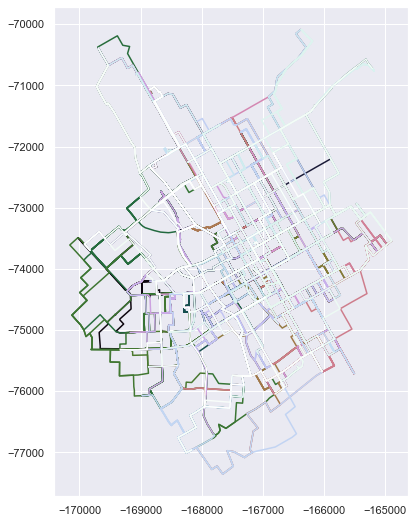

In [153]:
trips_gdf.loc[trips_gdf.start_region=="San Jose"].geometry.explode().plot(figsize=(9,9), cmap='cubehelix')

In [90]:
polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),Polygon([(2,2), (4,2), (4,4), (2,4)])])
polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),Polygon([(3,3), (5,3), (5,5), (3,5)])])
df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})
df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})
# merge the two GeoDataframe
cloudNshadow = gpd.overlay(df1, df2, how='union')
print(cloudNshadow)

   df1  df2                                           geometry
0  1.0  1.0  POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....
1  2.0  1.0  POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3....
2  2.0  2.0  POLYGON ((3.00000 4.00000, 4.00000 4.00000, 4....
3  1.0  NaN  POLYGON ((0.00000 0.00000, 0.00000 2.00000, 1....
4  2.0  NaN  MULTIPOLYGON (((2.00000 3.00000, 2.00000 4.000...
5  NaN  1.0  MULTIPOLYGON (((1.00000 2.00000, 1.00000 3.000...
6  NaN  2.0  POLYGON ((3.00000 4.00000, 3.00000 5.00000, 5....


In [91]:
print(cloudNshadow.geometry.unary_union.wkt) 

POLYGON ((0 0, 0 2, 1 2, 1 3, 2 3, 2 4, 3 4, 3 5, 5 5, 5 3, 4 3, 4 2, 3 2, 3 1, 2 1, 2 0, 0 0))


## EVEN MORE TESTING

In [83]:
# trips_eb.head()
# ox.get_nearest_node(G, (trips_eb.iloc[100]['start_station_latitude'], trips_eb.iloc[100]['start_station_longitude']), )

In [85]:
# trips_eb.iloc[0]['start_station_latitude'], trips_eb.iloc[0]['start_station_longitude']

In [84]:
# trips_eb['origin_node'] = trips_eb.apply(lambda x: ox.get_nearest_node(G, (x.start_station_latitude, x.start_station_longitude)))

In [53]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.868666, -122.259166) # Bancroft and Telegraph
destination_point = (37.851554, -122.252280) # College and Alcatraz
origin_node = ox.get_nearest_node(G0, origin_point)
destination_node = ox.get_nearest_node(G0, destination_point)
origin_node, destination_node

(53080628, 5486906949)

In [55]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G0, origin_node, destination_node, weight='length')
str(route)

'[53080628, 394220748, 53006324, 53103804, 53063553, 53041092, 4621435721, 53020976, 275804265, 53082748, 53085618, 53079150, 53111890, 53099277, 5060958939, 53070407, 53103280, 56837383, 53100516, 53037921, 53082594, 53100520, 53100523, 53090686, 3245435930, 3245435929, 53070069, 53090689, 5486906949]'

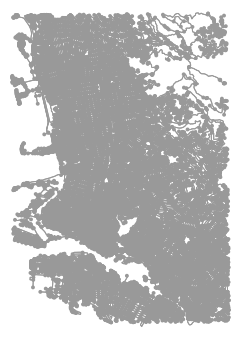

In [95]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G1, route, origin_point=origin_point, destination_point=destination_point)

In [88]:
# define a lat-long point, create network around point, define origin/destination nodes
location_point = (37.791427, -122.410018)
G = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='bike')

In [89]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(65343969, 65290756)

In [90]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[65343969, 65307397, 65295324, 65295320, 65295314, 7332987498, 7332987493, 6319217963, 6319217961, 6319217960, 65319944, 6319217971, 65290756]'

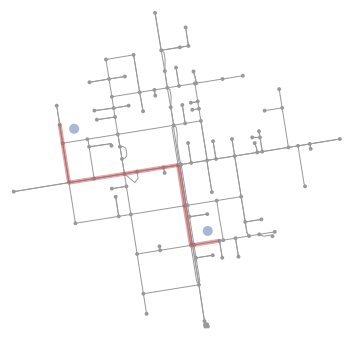

In [91]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

## How to save to .html file...don't delete yet

In [103]:
from IPython.display import IFrame

In [167]:
# download the street network for Piedmont, CA
G = ox.graph_from_place('Berkeley, California, USA', network_type='bike', retain_all='False', simplify=True)

In [164]:
G?

In [129]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [130]:
# save as html file then display map as an iframe
filepath = '../data/graph.html'
graph_map.save(filepath)
# IFrame(filepath, width=600, height=500)

In [220]:
# use networkx to calculate the shortest path between two nodes
origin_point = (37.868719, -122.259174)
origin_node = ox.get_nearest_node(G, origin_point)
destination_point = (37.851623, -122.252217)
destination_node = ox.get_nearest_node(G, destination_point)
# origin_node = list(G.nodes())[0]
# destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node, weight="length")

In [221]:
print(origin_point, destination_point)
print(origin_node, destination_node)
print(route)

(37.868719, -122.259174) (37.851623, -122.252217)
53080628 5486906949
[53080628, 53099275, 53063555, 53041093, 53020977, 53020979, 4631429373, 5484497299, 53070406, 53070407, 2415284475, 56837380, 4551722985, 53037916, 53037919, 53082593, 53103284, 283272945, 283272947, 53100523, 53099164, 53090689, 5486906949]


In [222]:
# plot the route with folium
# route_map = ox.plot_route_folium(G, route)

# plot the route with folium on top of the previously created graph_map
route_graph_map = ox.plot_route_folium(G, route, route_map=graph_map, popup_attribute='length')

In [223]:
# save as html file then display map as an iframe
filepath = '../data/route_graph.html'
route_graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [214]:
point2 = (37.790495, -122.408353)
point2 = (37.888433, -122.272654)
ox.get_nearest_node(G, point2, return_dist=True)

(348192780, 0.04533549020388037)

LINESTRING (-122.2591864 37.8687053, -122.2590046 37.8678138, -122.258817 37.8669135, -122.2586383 37.8660287, -122.2584543 37.8651268, -122.2578102 37.8652096, -122.2577527 37.8646457, -122.257711 37.8642071, -122.2576343 37.8633691, -122.2574514 37.861562, -122.2573647 37.8615673, -122.2570972 37.8604184, -122.257095 37.860393, -122.2570407 37.8597622, -122.2558087 37.859843, -122.2556922 37.8581643, -122.2555109 37.8567252, -122.2550331 37.8558607, -122.2549659 37.8558232, -122.2540224 37.855943, -122.2537792 37.8537702, -122.2527488 37.8539022, -122.2525226 37.851636)


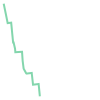

In [228]:
# https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html
from shapely.geometry import LineString, Point

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
# path = nx.shortest_path(G, list(G.nodes())[0], list(G.nodes())[1])
route_nodes = gdf_nodes.loc[route]

route_line = LineString(list(route_nodes.geometry.values))
print(route_line)
route_line

# DONT DELETE CELL THIS MAY BE USEFUL!

In [218]:
print(gdf_nodes.y.min(), gdf_nodes.y.max())
print(gdf_nodes.x.min(), gdf_nodes.x.max())

37.8463312 37.9046164
-122.3195267 -122.2359026
